In [13]:
import os
import warnings
import argparse

import numpy as np
import pandas as pd
import scanpy as sc
import torch
import matplotlib.pyplot as plt

import Riff
os.environ['R_HOME'] = '/usr/lib/R'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings("ignore")

# 1. Set parameters

In [4]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument("--seeds", type=int, default=42)
parser.add_argument("--device", type=int, default=3)
parser.add_argument("--encoder", type=str, default="gin")
parser.add_argument("--decoder", type=str, default="gin")
parser.add_argument("--num_hidden", type=int, default=64, help="number of hidden units")
parser.add_argument("--num_layers", type=int, default=2, help="number of hidden layers")
parser.add_argument("--activation", type=str, default="elu")
parser.add_argument("--num_heads", type=int, default=4, help="number of hidden attention heads")
parser.add_argument("--num_out_heads", type=int, default=1, help="number of output attention heads")
parser.add_argument("--residual", action="store_true", default=False, help="use residual connection")
parser.add_argument("--in_drop", type=float, default=0.2, help="input feature dropout")
parser.add_argument("--attn_drop", type=float, default=0.1, help="attention dropout")
parser.add_argument("--negative_slope", type=float, default=0.2, help="the negative slope of leaky relu for GAT")
parser.add_argument("--drop_edge_rate", type=float, default=0.0)
parser.add_argument("--alpha_l", type=float, default=4, help="`pow`inddex for `sce` loss")
parser.add_argument("--beta_l", type=float, default=2, help="`pow`inddex for `weighted_mse` loss")   
parser.add_argument("--loss_fn", type=str, default="weighted_mse")
parser.add_argument("--mask_gene_rate", type=float, default=0.8)
parser.add_argument("--replace_rate", type=float, default=0.05)
parser.add_argument("--remask_rate", type=float, default=0.5)
parser.add_argument("--warm_up", type=int, default=50)
parser.add_argument("--norm", type=str, default="batchnorm") 

# explain model parameters
parser.add_argument("--sample_num", type=int, default=1, help="number of nodes for explaination")
parser.add_argument("--optimizer", type=str, default="adam")
parser.add_argument("--mask_act", type=str, default="sigmoid")
parser.add_argument("--mask_bias", action="store_true", default=True)
parser.add_argument("--scheduler", action="store_true", default=True)
parser.add_argument("--max_epoch", type=int, default=10000, help="number of training epochs")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate for explaination")
parser.add_argument("--weight_decay", type=float, default=1e-4, help="weight decay for evaluation")

# RIF parameter
parser.add_argument("--adj_max_num", type=int, default=3)
parser.add_argument("--feat_max_num", type=int, default=-1)
parser.add_argument("--feat_min_num", type=int, default=10)
parser.add_argument("--feat_threshold", type=float, default=3)
parser.add_argument("--num_neighbors", type=int, default=15)
parser.add_argument("--num_features", type=int, default=3000) 
parser.add_argument("--sample_name", type=str, default="MouseOlfactoryBulb")
parser.add_argument("--seq_tech", type=str, default="Stereo-seq")
parser.add_argument("--cluster_label", type=str, default="")
parser.add_argument("--data_folder", type=str, default="/home/wcy/code/datasets/Stereo-seq/")
parser.add_argument("--num_classes", type=int, default=7, help="The number of clusters")
parser.add_argument("--output_folder", type=str, default="/home/wcy/code/pyFile/NewFolder/GSG_modified_DLPFH/output/")

args = parser.parse_args(args=['--sample_name', 'MouseOlfactoryBulb']) 
args

Namespace(activation='elu', adj_max_num=3, alpha_l=4, attn_drop=0.1, beta_l=2, cluster_label='', data_folder='/home/wcy/code/datasets/Stereo-seq/', decoder='gin', device=3, drop_edge_rate=0.0, encoder='gin', feat_max_num=-1, feat_min_num=10, feat_threshold=3, in_drop=0.2, loss_fn='weighted_mse', lr=0.001, mask_act='sigmoid', mask_bias=True, mask_gene_rate=0.8, max_epoch=10000, negative_slope=0.2, norm='batchnorm', num_classes=7, num_features=3000, num_heads=4, num_hidden=64, num_layers=2, num_neighbors=15, num_out_heads=1, optimizer='adam', output_folder='/home/wcy/code/pyFile/NewFolder/GSG_modified_DLPFH/output/', remask_rate=0.5, replace_rate=0.05, residual=False, sample_name='MouseOlfactoryBulb', sample_num=1, scheduler=True, seeds=42, seq_tech='Stereo-seq', warm_up=50, weight_decay=0.0001)

# 2. Preprocessing

In [5]:
Riff.set_random_seed(args.seeds)
data_path = args.data_folder + args.sample_name
adata = Riff.read_h5ad(data_path)

if(args.cluster_label == ""):
    num_classes = args.num_classes
else:
    num_classes = adata.obs[args.cluster_label].nunique()
adata, graph = Riff.build_graph(args, adata, need_preclust=False)

adata_path = os.path.join(args.output_folder, "adata/"+args.sample_name+".h5ad")
adata_imputed = sc.read_h5ad(adata_path)

=============== Contructing graph =================


# 3. SVG detection

In [6]:
selected_feats = set()
for i in range(num_classes):
    torch.cuda.empty_cache()
    print("Domain:" + str(i))
    selected_feat = Riff.find_influential_component(args, adata_imputed, graph, i)
    selected_feats = selected_feats.union(set(selected_feat))

selected_feats = list(selected_feats)
print(str(len(selected_feats)) + "SVG finded!")
svg_path = args.output_folder + "/SVG/" + str(args.sample_name) + ".txt"
f = open(svg_path, 'w')
for line in selected_feats:
    f.write(line+"\n")
f.close()

Domain:0


# Epoch 929: loss: 1.37, p_feat: 0.73:   9%|███████████████▊                                                                                                                                                          | 930/10000 [43:17<7:02:08,  2.79s/it]


Domain:1


# Epoch 15: loss: 1.72, p_feat: 0.03:   0%|▎                                                                                                                                                                           | 16/10000 [00:44<7:38:53,  2.76s/it]


Domain:2


# Epoch 1283: loss: 1.61, p_feat: 1.03:  13%|█████████████████████▌                                                                                                                                                  | 1284/10000 [55:47<6:18:44,  2.61s/it]


Domain:3


# Epoch 10: loss: 1.31, p_feat: 0.03:   0%|▏                                                                                                                                                                           | 11/10000 [00:32<8:05:12,  2.91s/it]


Domain:4


# Epoch 264: loss: 1.39, p_feat: 0.25:   3%|████▌                                                                                                                                                                     | 265/10000 [11:42<7:10:07,  2.65s/it]


Domain:5


# Epoch 70: loss: 1.45, p_feat: 0.09:   1%|█▏                                                                                                                                                                          | 71/10000 [02:59<6:57:46,  2.52s/it]


Domain:6


# Epoch 133: loss: 1.41, p_feat: 0.14:   1%|██▎                                                                                                                                                                       | 134/10000 [05:42<7:00:06,  2.55s/it]

294SVG finded!


# 4. SVG visualization

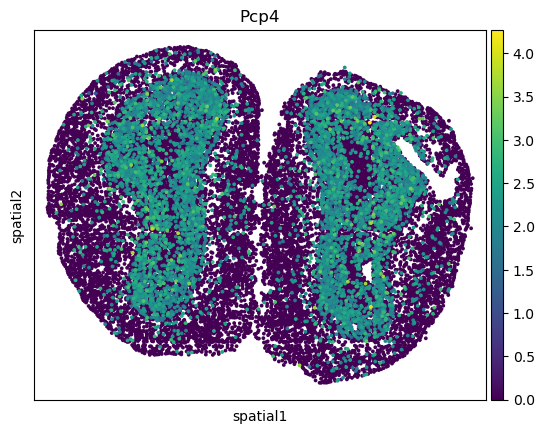

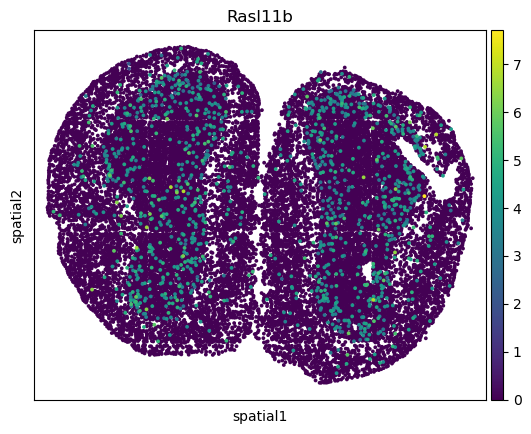

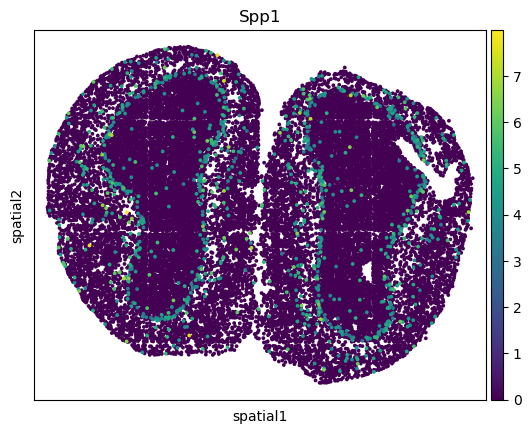

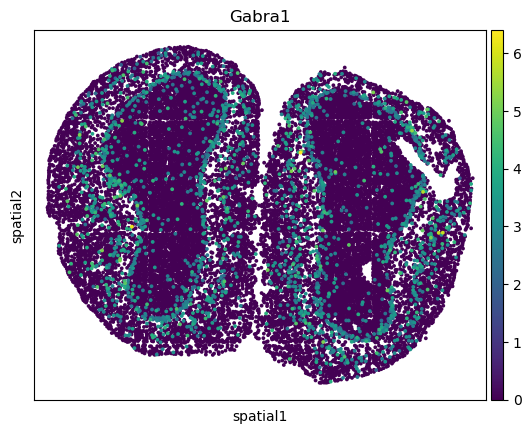

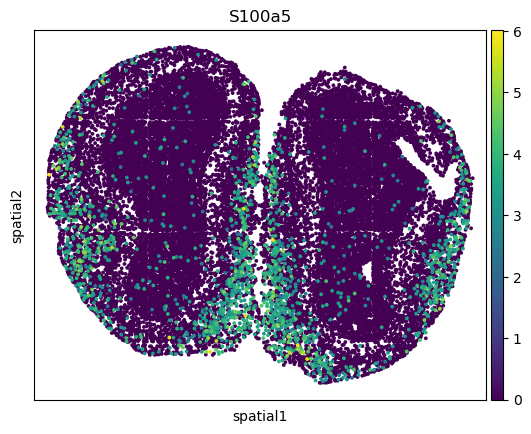

In [17]:
spatial = adata.obsm['spatial'].copy()
spatial[:,0] = adata.obsm['spatial'].copy()[:, 1]
spatial[:,1] = adata.obsm['spatial'].copy()[:, 0]
adata.obsm['spatial'] = spatial

test_gene_list = ['Pcp4', 'Rasl11b', 'Spp1', 'Gabra1', 'S100a5']
for gene in test_gene_list:
    if gene in selected_feats:
        sc.pl.embedding(adata, basis='spatial', color=gene, s=30, show=False)
        plt.axis('equal')